<a href="https://colab.research.google.com/github/hassanSattariNia/prediction_time_series/blob/main/muBenchSingleVariablePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
26/26 [==============================] - 4s 30ms/step - loss: 0.4616 - mse: 0.4616 - mae: 0.5095 - val_loss: 0.7469 - val_mse: 0.7469 - val_mae: 0.8481 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0773 - mse: 0.0773 - mae: 0.1958 - val_loss: 0.6117 - val_mse: 0.6117 - val_mae: 0.7637 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 0s 13ms/step - loss: 0.0423 - mse: 0.0423 - mae: 0.1354 - val_loss: 0.5895 - val_mse: 0.5895 - val_mae: 0.7437 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0514 - mse: 0.0514 - mae: 0.1592 - val_loss: 0.5831 - val_mse: 0.5831 - val_mae: 0.7313 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 0s 17ms/step - loss: 0.0563 - mse: 0.0563 - mae: 0.1608 - val_loss: 0.5897 - val_mse: 0.5897 - val_mae: 0.7270 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0539 - mse: 0.0539 - mae: 0.1620 - val_

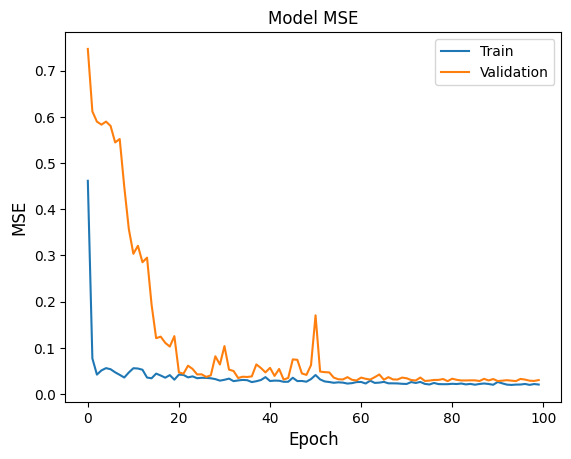

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

def preprocess(data_array: np.ndarray, train_size: float):
    """Splits data into train/val/test sets and normalizes the data."""
    num_time_steps = data_array.shape[0]
    num_train = int(num_time_steps * train_size)
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)
    train_array = (train_array - mean) / std
    test_array = (data_array[num_train:] - mean) / std
    return train_array, test_array

# Load your data
data = pd.read_csv('/content/number_services_called.csv').fillna(0)
data['Future_Value'] = data.iloc[:, 0].shift(-1).dropna()
data = data.to_numpy()


# Preprocess the data
train_array, test_array = preprocess(data, 0.7)

x_train = train_array[:, :-1]  # All columns except the last one
y_train = train_array[:, -1]   # Only the last column

# For testing data
x_test = test_array[:, :-1]    # All columns except the last one
y_test = test_array[:, -1]     # Only the last column

# Reshape the data for the model
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))  # Reshape y_train to be 2D
y_test = y_test.reshape((y_test.shape[0], 1))    # Reshape y_test to be 2D


# Shuffle the training set
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(input_shape[0])(gap)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001)
]

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mse","mae"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

model = keras.models.load_model("best_model.keras")

test_loss, test_mse, test_mae = model.evaluate(x_test, y_test)

print("Test Loss", test_loss)
print("Test MSE", test_mse)
print("Test MAE", test_mae)

plt.figure()
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
plt.title("Model MSE")
plt.ylabel("MSE", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Validation"], loc="best")
plt.show()
plt.close()
